<a href="https://colab.research.google.com/github/casllmproject/wjs_llm_project/blob/main/USUKDE_human_ai_alignments_Dec2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount goolge drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Read the CSV file with its current encoding (e.g., ISO-8859-1)
input_file = '/content/drive/MyDrive/AI_shoes/wjs_usukde.csv'
output_file = '/content/drive/MyDrive/AI_shoes/wjs_usukde_utf8.csv'

# Load the file
df = pd.read_csv(input_file, encoding='ISO-8859-1')

# Save the file with UTF-8 encoding
df.to_csv(output_file, index=False, encoding='utf-8')

print(f"Converted the CSV file to UTF-8 and saved it as {output_file}.")

<ipython-input-4-8d169cbd3c8e>:6: DtypeWarning: Columns (13,53,54,154) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file, encoding='ISO-8859-1')


Converted the CSV file to UTF-8 and saved it as /content/drive/MyDrive/AI_shoes/wjs_usukde_utf8.csv.


In [ ]:
# Load human responses
human_df = pd.read_csv('/content/drive/MyDrive/AI_shoes/wjs_usukde_utf8.csv')

# Replace 777 and 999 with NaN
human_df.replace({777: pd.NA, 999: pd.NA}, inplace=True)

# Save the updated dataset
human_df.to_csv('/content/drive/MyDrive/AI_shoes/wjs_usukde_cleaned.csv', index=False)

print("Replaced 777 and 999 with NA and saved the cleaned dataset.")


<ipython-input-5-96e4654bf364>:2: DtypeWarning: Columns (13,53,54,154) have mixed types. Specify dtype option on import or set low_memory=False.
  human_df = pd.read_csv('/content/drive/MyDrive/AI_shoes/wjs_usukde_utf8.csv')


Replaced 777 and 999 with NA and saved the cleaned dataset.


In [ ]:
# Load the CSV file with low_memory=False
human_df = pd.read_csv('/content/drive/MyDrive/AI_shoes/wjs_usukde_cleaned.csv', low_memory=False)


In [ ]:
# Replace non-numeric values with NaN and convert all columns to numeric
human_df = human_df.apply(pd.to_numeric, errors='coerce')

# Optionally, fill NaN values with a specific integer, e.g., 0
human_df = human_df.fillna(0).astype(int)
# Rename the column
human_df.rename(columns={'ï»¿COUNTRY': 'COUNTRY'}, inplace=True)


In [ ]:
# Apply across all variables to make 777, and 999 as missing
human_df = human_df.applymap(lambda x: np.nan if x in [777, 999] else x)

# For 'gender': Keep only 1 and 2, others as missing
human_df['gender'] = human_df['gender'].apply(lambda x: x if x in [1, 2] else np.nan)

# For 'empl': Combine 1 and 3 as 1, 2 and 4 as 2, 5 stays as 5, others as missing
human_df['empl'] = human_df['empl'].apply(lambda x: 1 if x in [1, 3] else (2 if x in [2, 4] else (5 if x == 5 else np.nan)))

# For 'mbackg': Make 7, 8, and 9 as missing
human_df['mbackg'] = human_df['mbackg'].apply(lambda x: x if x not in [7, 8, 9] else np.nan)

# For 'gen_edu': Make 1, 2, 5 as missing
human_df['gen_edu'] = human_df['gen_edu'].apply(lambda x: x if x not in [1, 2, 5] else np.nan)

# Display the updated DataFrame
print(human_df)

      COUNTRY  STATUS  job_ttle  empl  empl6  incm_j  empl_c1  empl_c2  \
0          28       0         0   5.0      0   100.0        0        0   
1          28       0         0   5.0      0    90.0        0        0   
2          28       0         0   5.0      0   100.0        0        0   
3          28       0         0   1.0      0   100.0        0        0   
4          28       0         0   5.0      0    80.0        0        0   
...       ...     ...       ...   ...    ...     ...      ...      ...   
3674       72       0         0   1.0      0   100.0        0        0   
3675       72       0         0   1.0      0   100.0        0        0   
3676       72       0         0   1.0      0   100.0        0        0   
3677       72       0         0   1.0      0   100.0        0        0   
3678       72       0         0   1.0      0   100.0        0        0   

      incm_o_A  incm_o_B  ...  WB_GDPC_GROW  WP_GNI_GROW  Country_strg  \
0          0.0       0.0  ...        

<ipython-input-8-a6017da3b806>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  human_df = human_df.applymap(lambda x: np.nan if x in [777, 999] else x)


In [ ]:
print(human_df.columns)

Index(['COUNTRY', 'STATUS', 'job_ttle', 'empl', 'empl6', 'incm_j', 'empl_c1',
       'empl_c2', 'incm_o_A', 'incm_o_B',
       ...
       'WB_GDPC_GROW', 'WP_GNI_GROW', 'Country_strg', 'lca_group', 'mon',
       'adv', 'dev', 'ins', 'mob', 'pol_cat'],
      dtype='object', length=258)


In [ ]:
# Function to compute distribution of human responses by group
def compute_distribution(df, variable_name, group):
    distribution = df.groupby(group)[variable_name].value_counts(normalize=True).unstack().fillna(0)
    return distribution

# Create political ideological groups
def categorize_political_view(df):
    conditions = [
        (df['pol_view'] <= 4),
        (df['pol_view'] == 5),
        (df['pol_view'] >= 6)
    ]
    choices = ['left', 'center', 'right']
    df['pol_view_group'] = np.select(conditions, choices, default=pd.NA)
    return df

# Employment status consolidation
def consolidate_employment_status(df):
    consolidated_empl_mapping = {
        1: 1,  # Full-time
        2: 2,  # Part-time

    }
    df['empl'] = df['empl'].replace(consolidated_empl_mapping)
    return df

# Apply all categorizations to the DataFrame
def preprocess_human_df(df):
    df = categorize_political_view(df)
    df = consolidate_employment_status(df)
    return df

# Label mappings
gender_labels = {1: 'Female', 2: 'Male'}
empl_labels = {1: 'Full-time', 2: 'Part-time', 5: 'Freelance or self-employed'}
mbackg_labels = {
    1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio', 5: 'News agency',
    6: 'Internet native'
}
gen_edu_labels = {
    3: 'Bachelor’s degree or equivalent', 4: 'Master\'s degree or equivalent',
    6: 'Undertook some university studies, but no degree'
}
country_labels = {
    28: "Germany", 71: "UK", 72: "USA"
}

# Function to map labels
def map_labels(distribution, labels):
    return distribution.rename(index=labels)

# Function to calculate and print distribution for different grouping variables
def compute_and_print_distributions(df, variable_name):
    # Political view group distribution
    political_distribution = compute_distribution(df, variable_name, 'pol_view_group')
    print(f"Distribution by political view group on {variable_name}:")
    print(political_distribution)

    # Gender distribution
    gender_distribution = compute_distribution(df, variable_name, 'gender')
    gender_distribution = map_labels(gender_distribution, gender_labels)
    print(f"\nDistribution by gender on {variable_name}:")
    print(gender_distribution)

    # Employment status distribution
    employment_distribution = compute_distribution(df, variable_name, 'empl')
    employment_distribution = map_labels(employment_distribution, empl_labels)
    print(f"\nDistribution by employment status on {variable_name}:")
    print(employment_distribution)

    # Media background distribution
    media_background_distribution = compute_distribution(df, variable_name, 'mbackg')
    media_background_distribution = map_labels(media_background_distribution, mbackg_labels)
    print(f"\nDistribution by media background on {variable_name}:")
    print(media_background_distribution)

    # General education distribution
    education_distribution = compute_distribution(df, variable_name, 'gen_edu')
    education_distribution = map_labels(education_distribution, gen_edu_labels)
    print(f"\nDistribution by general education on {variable_name}:")
    print(education_distribution)

    # Country distribution
    country_distribution = compute_distribution(df, variable_name, 'COUNTRY')
    country_distribution = map_labels(country_distribution, country_labels)
    print(f"\nDistribution by country on {variable_name}:")
    print(country_distribution)

# Example usage
human_df = preprocess_human_df(human_df)  # Apply preprocessing
compute_and_print_distributions(human_df, 'role_A')  # Calculate and print distributions for 'role_A'


Distribution by political view group on role_A:
role_A                 0         1         2         3         4         5
pol_view_group                                                            
center          0.002911  0.029112  0.033479  0.136827  0.401747  0.395924
left            0.002146  0.042060  0.077253  0.204292  0.306009  0.368240
right           0.006897  0.055172  0.050575  0.149425  0.294253  0.443678

Distribution by gender on role_A:
role_A         0         1         2         3         4        5
gender                                                           
Female  0.002252  0.046171  0.064189  0.190878  0.308559  0.38795
Male    0.002971  0.039216  0.059418  0.168152  0.333333  0.39691

Distribution by employment status on role_A:
role_A                             0         1         2         3         4  \
empl                                                                           
Full-time                   0.002883  0.039640  0.062703  0.178739  0.31

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import wasserstein_distance

# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    distances = {}
    for group in human_distribution.index:  # Loop through groups like 'left', 'Female', etc.
        options = human_distribution.columns.astype(int)
        human_probs = human_distribution.loc[group].values
        gpt_value = int(gpt_response)

        # Convert gpt_value to a list and ensure it is in the same range as options
        gpt_probs = np.zeros_like(human_probs)
        if gpt_value in options:
            gpt_probs[options.get_loc(gpt_value)] = 1

        # Compute Wasserstein distance
        distance = wasserstein_distance(gpt_probs, human_probs)
        distances[group] = distance
    return distances

# Function to compute and display Wasserstein distances for each group
def compute_and_display_distances(df, variable_name, gpt_response, group_col, group_labels, group_name):
    human_distribution = compute_distribution(df, variable_name, group_col)
    distances = compute_wasserstein_distance(human_distribution, gpt_response)

    print(f'\nWasserstein Distances between {gpt_model} and {group_name} distributions for "{variable_name}":')
    for group, distance in distances.items():
        label = group_labels.get(group, group)
        print(f"{label}: {distance}")

# Define updated labels for each grouping variable
pol_view_labels = {'left': 'Left', 'center': 'Center', 'right': 'Right'}
gender_labels = {1: 'Female', 2: 'Male'}
empl_labels = {1: 'Full-time', 2: 'Part-time', 5: 'Freelance or self-employed'}
mbackg_labels = {
    1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio', 5: 'News agency',
    6: 'Internet native'
}
gen_edu_labels = {
    3: 'Bachelor’s degree or equivalent', 4: 'Master\'s degree or equivalent',
    6: 'Undertook some university studies, but no degree'
}
country_labels = {28: "Germany", 71: "UK", 72: "USA"}

# Example: Compute Wasserstein distance for GPT-4o's response for 'role_A'
gpt_model = 'gpt-4o-2024-08-06'
gpt_responses_df = pd.read_csv(f'/content/drive/MyDrive/AI_shoes/gpt-4o-2024-08-06_responses.csv')

# Find the response for 'role_A' in the GPT responses CSV
gpt_response = gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == 'role_A', 'Response'].values[0]

# Apply political view group categorization
human_df = categorize_political_view(human_df)

# Consolidate employment statuses
human_df = consolidate_employment_status(human_df)

# Calculate and display Wasserstein distances for each grouping variable
compute_and_display_distances(human_df, 'role_A', gpt_response, 'pol_view_group', pol_view_labels, 'political view')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'gender', gender_labels, 'gender')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'empl', empl_labels, 'employment status')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'mbackg', mbackg_labels, 'media background')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'gen_edu', gen_edu_labels, 'general education')
compute_and_display_distances(human_df, 'role_A', gpt_response, 'COUNTRY', country_labels, 'COUNTRY')


Wasserstein Distances between gpt-4o-2024-08-06 and political view distributions for "role_A":
Center: 0.19941775836972342
Left: 0.21058655221745348
Right: 0.18544061302681994

Wasserstein Distances between gpt-4o-2024-08-06 and gender distributions for "role_A":
Female: 0.2040165165165165
Male: 0.20102990691225986

Wasserstein Distances between gpt-4o-2024-08-06 and employment status distributions for "role_A":
Full-time: 0.20108108108108108
Part-time: 0.19662921348314605
Freelance or self-employed: 0.21139601139601139

Wasserstein Distances between gpt-4o-2024-08-06 and media background distributions for "role_A":
0.0: 0.2222222222222222
Newspaper: 0.1958997722095672
Magazine: 0.2072232089994079
TV: 0.17834078489816196
Radio: 0.18666666666666668
News agency: 0.16460905349794236
Internet native: 0.22101449275362317

Wasserstein Distances between gpt-4o-2024-08-06 and general education distributions for "role_A":
0.0: 0.21538461538461534
Bachelor’s degree or equivalent: 0.205745669623

In [ ]:
# Function to calculate overall Mean and Standard Deviation
def calculate_overall_mean_and_sd(all_distances):
    overall_distances = [distance for group_distances in all_distances.values() for distance in group_distances.values()]
    mean_distance = np.mean(overall_distances)
    sd_distance = np.std(overall_distances)
    return mean_distance, sd_distance

In [ ]:
# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    distances = {}
    for group in human_distribution.index:  # Loop through groups like 'left', 'Female', etc.
        options = human_distribution.columns.astype(int)
        human_probs = human_distribution.loc[group].values
        gpt_value = int(gpt_response)

        # Convert gpt_value to a list and ensure it is in the same range as options
        gpt_probs = np.zeros_like(human_probs)
        if gpt_value in options:
            gpt_probs[options.get_loc(gpt_value)] = 1

        # Compute Wasserstein distance
        distance = wasserstein_distance(gpt_probs, human_probs)
        distances[group] = distance
    return distances

# Function to compute and display Wasserstein distances and overall statistics
def compute_and_display_distances(df, variable_name, gpt_response, group_col, group_labels, group_name):
    human_distribution = compute_distribution(df, variable_name, group_col)
    distances = compute_wasserstein_distance(human_distribution, gpt_response)

    # Display distances for each group
    print(f'\nWasserstein Distances between {gpt_model} and {group_name} distributions for "{variable_name}":')
    for group, distance in distances.items():
        label = group_labels.get(group, group)
        print(f"{label}: {distance}")

    # Return the group-wise distances for aggregation later
    return distances

# Aggregate all Wasserstein distances for overall statistics
def aggregate_and_display_overall_statistics(all_distances):
    # Compute overall Mean and SD across all grouping variables
    mean_distance, sd_distance = calculate_overall_mean_and_sd(all_distances)

    print("\nOverall Statistics across all grouping variables:")
    print(f"Mean (M): {mean_distance:.4f}")
    print(f"Standard Deviation (SD): {sd_distance:.4f}")

# Main execution with overall statistics computation
gpt_model = 'gpt-4o-2024-08-06'
gpt_responses_df = pd.read_csv(f'/content/drive/MyDrive/AI_shoes/gpt-4o-2024-08-06_responses.csv')

# Find the response for 'role_A' in the GPT responses CSV
gpt_response = gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == 'role_A', 'Response'].values[0]

# Apply political view group categorization
human_df = categorize_political_view(human_df)

# Consolidate employment statuses
human_df = consolidate_employment_status(human_df)

# Compute and collect Wasserstein distances for all grouping variables
all_distances = {}
all_distances['political view'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'pol_view_group', pol_view_labels, 'political view')
all_distances['gender'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'gender', gender_labels, 'gender')
all_distances['employment status'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'empl', empl_labels, 'employment status')
all_distances['media background'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'mbackg', mbackg_labels, 'media background')
all_distances['general education'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'gen_edu', gen_edu_labels, 'general education')
all_distances['COUNTRY'] = compute_and_display_distances(human_df, 'role_A', gpt_response, 'COUNTRY', country_labels, 'COUNTRY')

# Compute and display overall statistics across all groups
aggregate_and_display_overall_statistics(all_distances)


Wasserstein Distances between gpt-4o-2024-08-06 and political view distributions for "role_A":
Center: 0.19941775836972342
Left: 0.21058655221745348
Right: 0.18544061302681994

Wasserstein Distances between gpt-4o-2024-08-06 and gender distributions for "role_A":
Female: 0.2040165165165165
Male: 0.20102990691225986

Wasserstein Distances between gpt-4o-2024-08-06 and employment status distributions for "role_A":
Full-time: 0.20108108108108108
Part-time: 0.19662921348314605
Freelance or self-employed: 0.21139601139601139

Wasserstein Distances between gpt-4o-2024-08-06 and media background distributions for "role_A":
0.0: 0.2222222222222222
Newspaper: 0.1958997722095672
Magazine: 0.2072232089994079
TV: 0.17834078489816196
Radio: 0.18666666666666668
News agency: 0.16460905349794236
Internet native: 0.22101449275362317

Wasserstein Distances between gpt-4o-2024-08-06 and general education distributions for "role_A":
0.0: 0.21538461538461534
Bachelor’s degree or equivalent: 0.205745669623

In [ ]:
# Function to compute Wasserstein distances for all variables
def compute_wasserstein_for_variables(df, variables, gpt_responses, groupings):
    overall_results = {}  # To store results for all variables

    for variable_name in variables:
        print(f"\nProcessing variable: {variable_name}")
        gpt_response = gpt_responses.get(variable_name)
        if gpt_response is None:
            print(f"Warning: GPT response for '{variable_name}' not found.")
            continue

        variable_results = {}

        # Compute distances for each grouping
        for group_col, (group_labels, group_name) in groupings.items():
            print(f" - Grouping: {group_name}")
            distances = compute_and_display_distances(df, variable_name, gpt_response, group_col, group_labels, group_name)
            variable_results[group_name] = distances

        # Store results for the variable
        overall_results[variable_name] = variable_results

    return overall_results

# Function to compute overall mean and SD for all variables
def compute_overall_metrics(all_results):
    summary_metrics = {}

    for variable_name, group_results in all_results.items():
        all_distances = [
            distance for group_distances in group_results.values()
            for distance in group_distances.values()
        ]
        mean_distance = np.mean(all_distances)
        sd_distance = np.std(all_distances)
        summary_metrics[variable_name] = {"Mean (M)": mean_distance, "SD": sd_distance}

    return summary_metrics

In [ ]:
# Define groupings
groupings = {
    "pol_view_group": (pol_view_labels, "political view"),
    "gender": (gender_labels, "gender"),
    "empl": (empl_labels, "employment status"),
    "mbackg": (mbackg_labels, "media background"),
    "gen_edu": (gen_edu_labels, "general education"),
    "COUNTRY": (country_labels, "COUNTRY"),
}

In [ ]:
# Load GPT responses and variables
gpt_responses_df = pd.read_csv('/content/drive/MyDrive/AI_shoes/gpt-4o-2024-08-06_responses.csv')
gpt_responses = dict(zip(gpt_responses_df['Variable_Name'], gpt_responses_df['Response']))

# Define the list of variables to process
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D", "epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E",
             "role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]  # Replace with your full variable list

# Apply any necessary preprocessing to human_df
human_df = categorize_political_view(human_df)
human_df = consolidate_employment_status(human_df)

# Compute Wasserstein distances for all variables
all_results = compute_wasserstein_for_variables(human_df, variables, gpt_responses, groupings)

# Compute overall metrics (Mean and SD) for all variables
summary_metrics = compute_overall_metrics(all_results)

# Display summary metrics
print("\nSummary of Mean (M), SD, and CV for all variables:")
for variable, metrics in summary_metrics.items():
    mean = metrics['Mean (M)']
    sd = metrics['SD']
    cv = sd / mean if mean != 0 else 0  # Avoid division by zero
    print(f"{variable}: M = {mean:.4f}, SD = {sd:.4f}, CV = {cv:.4f}")


Processing variable: ethic1_A
 - Grouping: political view

Wasserstein Distances between gpt-4o-2024-08-06 and political view distributions for "ethic1_A":
Center: 0.14604560892770496
Left: 0.22374821173104434
Right: 0.21685823754789274
 - Grouping: gender

Wasserstein Distances between gpt-4o-2024-08-06 and gender distributions for "ethic1_A":
Female: 0.22785285285285287
Male: 0.22380669439492967
 - Grouping: employment status

Wasserstein Distances between gpt-4o-2024-08-06 and employment status distributions for "ethic1_A":
Full-time: 0.2303903903903904
Part-time: 0.2153558052434457
Freelance or self-employed: 0.2108262108262108
 - Grouping: media background

Wasserstein Distances between gpt-4o-2024-08-06 and media background distributions for "ethic1_A":
0.0: 0.21921921921921922
Newspaper: 0.22880283472538598
Magazine: 0.20367081113084665
TV: 0.2240437158469945
Radio: 0.21666666666666667
News agency: 0.22016460905349794
Internet native: 0.2258454106280193
 - Grouping: general edu

In [ ]:
# Define grouping variables as a global constant
GROUPING_VARIABLES = {
    'pol_view_group': {'left': 'Left', 'center': 'Center', 'right': 'Right'},
    'gender': {1: 'Female', 2: 'Male'},
    'empl': {
        1: 'Full-time',
        2: 'Part-time',
        5: 'Freelance'
    },
    'mbackg': {
        1: 'Newspaper', 2: 'Magazine', 3: 'TV', 4: 'Radio',
        5: 'News agency', 6: 'Internet native'
    },
    'gen_edu': {
        3: 'BA degree',
        4: 'MA degree',
        6: 'No formal degree'
    }
}

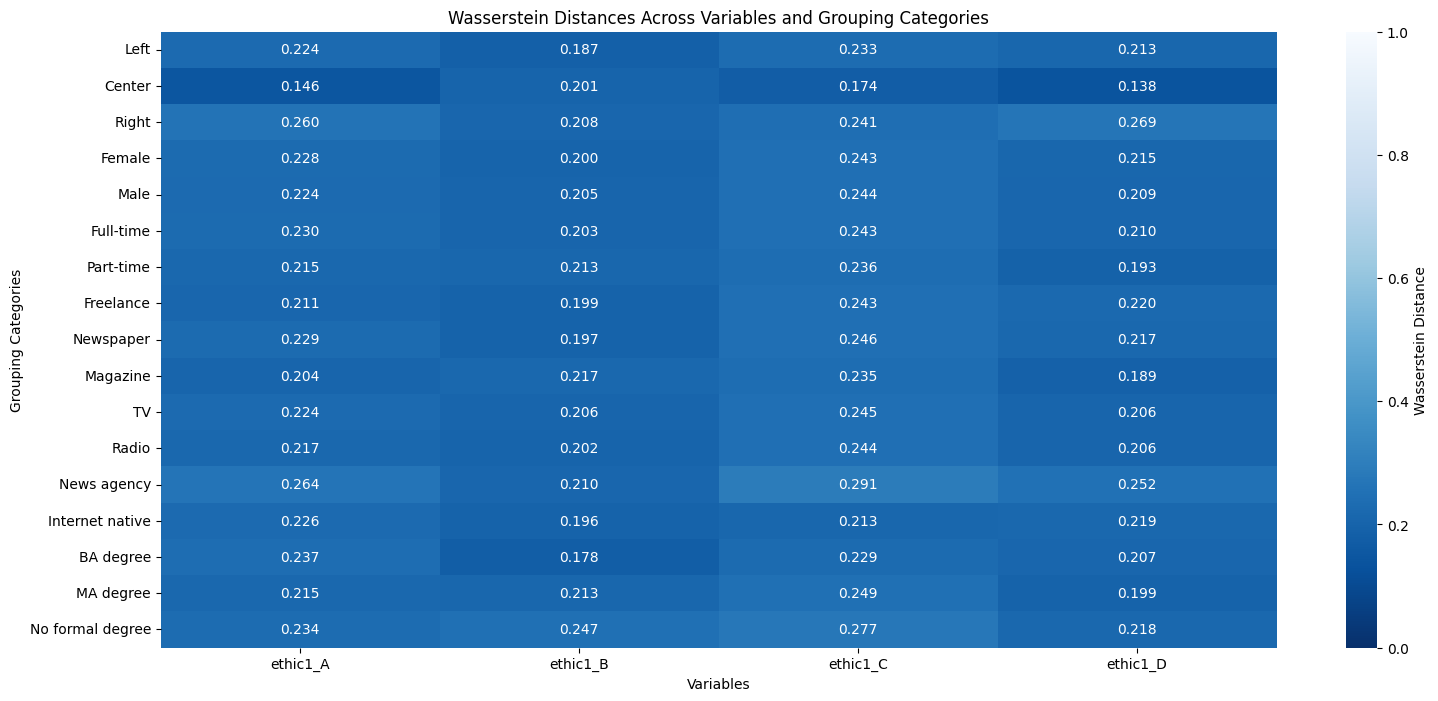

In [ ]:
# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate an integrated heatmap
def generate_integrated_heatmap(human_df, gpt_responses_df, variables, grouping_variables):
    # Initialize an empty DataFrame to store the results
    heatmap_data = pd.DataFrame(columns=variables)

    # Compute Wasserstein distances for each group and variable
    for group_col, group_labels in grouping_variables.items():
        for group, label in group_labels.items():
            row = {}
            for var in variables:
                gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
                human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

                # Check if the distribution is empty and skip if it is
                if not human_distribution.empty:
                    distance = compute_wasserstein_distance(human_distribution, gpt_response)
                    row[var] = distance
                else:
                    row[var] = np.nan

            # Add the row for this group
            heatmap_data.loc[label] = row

    # Create a heatmap with raw scores
    plt.figure(figsize=(18, 8))
    sns.heatmap(
        heatmap_data.astype(float),
        cmap='Blues_r',
        annot=True,
        fmt=".3f",
        vmin=0,
        vmax=1,
        cbar_kws={'label': 'Wasserstein Distance'}
    )
    plt.title('Wasserstein Distances Across Variables and Grouping Categories', fontsize=12)  # Smaller title size
    plt.xlabel('Variables')
    plt.ylabel('Grouping Categories')
    plt.show()

# Example usage
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D"]

# Generate the heatmap using the global GROUPING_VARIABLES
generate_integrated_heatmap(human_df, gpt_responses_df, variables, GROUPING_VARIABLES)

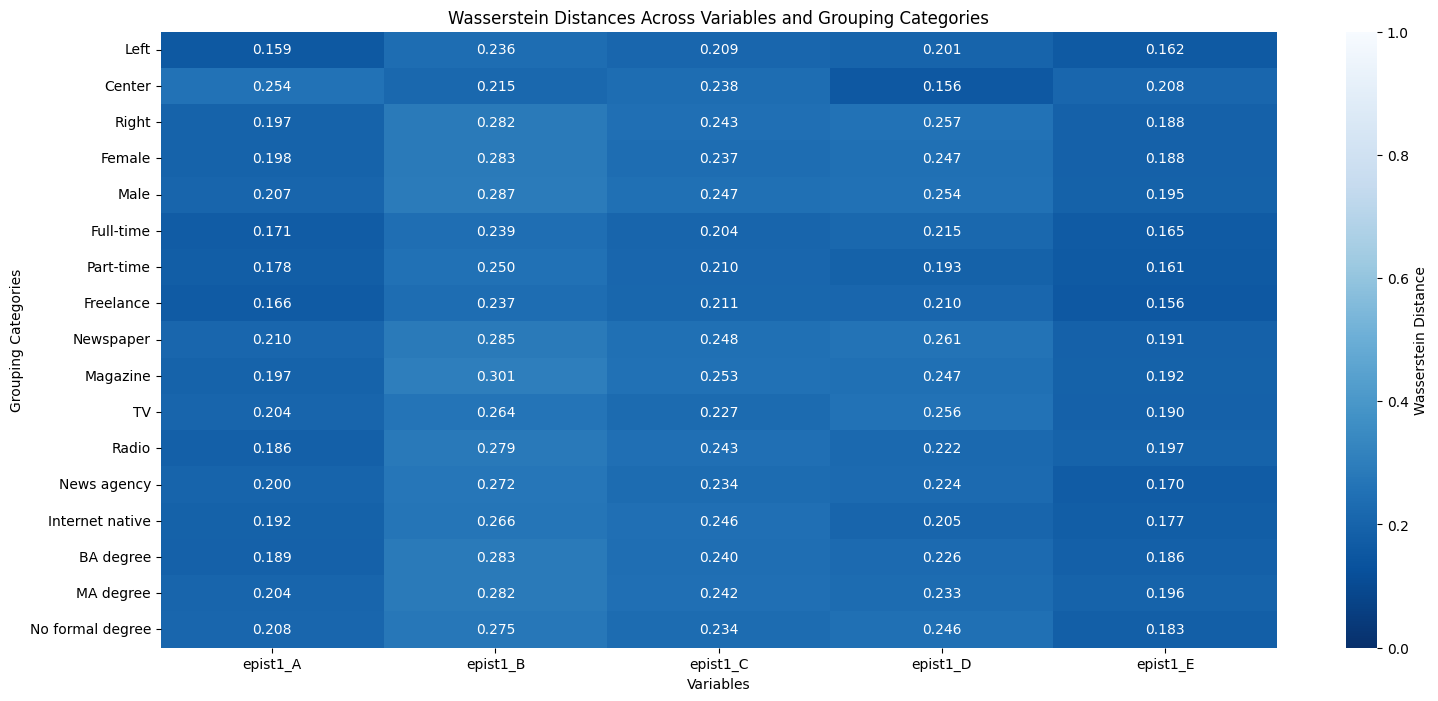

In [ ]:
# Function to compute Wasserstein distance between GPT response and human distribution
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate an integrated heatmap for all variables and grouping categories
def generate_integrated_heatmap(human_df, gpt_responses_df, variables, grouping_variables):
    # Initialize an empty DataFrame to store the results
    heatmap_data = pd.DataFrame(columns=variables)

    # Compute Wasserstein distances for each group and variable
    for group_col, group_labels in grouping_variables.items():
        for group, label in group_labels.items():
            row = {}
            for var in variables:
                gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
                human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

                # Check if the distribution is empty and skip if it is
                if not human_distribution.empty:
                    distance = compute_wasserstein_distance(human_distribution, gpt_response)
                    row[var] = distance
                else:
                    row[var] = np.nan

            # Add the row for this group
            heatmap_data.loc[label] = row

    # Create a heatmap with raw scores
    plt.figure(figsize=(18, 8))
    sns.heatmap(heatmap_data.astype(float), cmap='Blues_r', annot=True, fmt=".3f", vmin=0, vmax=1, cbar_kws={'label': 'Wasserstein Distance'})
    plt.title('Wasserstein Distances Across Variables and Grouping Categories', fontsize=12)  # Smaller title size
    plt.xlabel('Variables')
    plt.ylabel('Grouping Categories')
    plt.show()

# Example usage
variables = ["epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E"]

# Generate the heatmap using the global GROUPING_VARIABLES
generate_integrated_heatmap(human_df, gpt_responses_df, variables, GROUPING_VARIABLES)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm, colors as mcolors

# Define a color palette for different groupings
color_palette = {
    'pol_view_group': 'red',
    'gender': 'blue',
    'empl': 'green',
    'mbackg': 'purple',
    'gen_edu': 'orange'
}
# Custom labels for legend
legend_labels = {
    'pol_view_group': 'Political Groups',
    'gender': 'Gender',
    'empl': 'Employment Status',
    'mbackg': 'Background',
    'gen_edu': 'General Education'
}

def create_colormap(base_color):
    # Create a colormap with more distinct contrast by using a wider range
    base_rgb = np.array(mcolors.to_rgb(base_color))
    light_color = np.clip(base_rgb + 0.65, 0.65, 0.8)  # Increase to 0.7 to lighten more
    return mcolors.LinearSegmentedColormap.from_list('custom_cmap', [to_hex(light_color), base_color])

# Function to compute representativeness for each group
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        if group_distances:
            avg_representativeness = np.nanmean(group_distances)
        else:
            avg_representativeness = np.nan  # Handle empty cases

        row = {
            'Group': group_labels[group],
            'Representativeness': avg_representativeness,
            'Group_Column': group_col
        }
        rows_list.append(row)

    results_df = pd.DataFrame(rows_list)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the continuum plot
def generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables, plot_title):
    all_results = []

    for group_col, group_labels in grouping_variables.items():
        result = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_results.append(result)

    combined_df = pd.concat(all_results, ignore_index=True)

    # Filter data to be within the 0.5 to 1.0 range
    combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

    # Plotting
    plt.figure(figsize=(12, 8))

    for group_col, base_color in color_palette.items():
        group_data = combined_df[combined_df['Group_Column'] == group_col]

        # Create and use the custom colormap for each base color
        cmap = create_colormap(base_color)
        norm = Normalize(vmin=0.65, vmax=1.0)

        # Compute colors based on representativeness (darker as representativeness increases)
        colors = [cmap(norm(val)) for val in group_data['Representativeness']]

        # Compute sizes based on representativeness
        sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

        # Use the custom legend labels
        scatter = plt.scatter(
            x=group_data['Group'],
            y=group_data['Representativeness'],
            c=colors,
            s=sizes,
            edgecolor='black',
            label=legend_labels.get(group_col, group_col),  # Use custom label here
            alpha=0.7
        )

    # Add text labels on the dots
    for i in range(combined_df.shape[0]):
        plt.text(
            x=combined_df['Group'].iloc[i],
            y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
            s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
            ha='center',
            fontsize=9
        )

    # Add lines connecting the x-axis labels to the dots
    for i in range(combined_df.shape[0]):
        plt.plot(
            [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
            [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
            color='gray', linestyle='--', linewidth=0.5
        )

    plt.axhline(0.5, color='red', linestyle='--')
    plt.ylim(0.65, 0.85)
    plt.xlabel('Profile Group')
    plt.ylabel('Representativeness')
    plt.title(plot_title)  # Use the manually provided title
    plt.xticks(rotation=60)
    plt.legend(title='Group Column', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    plt.show()

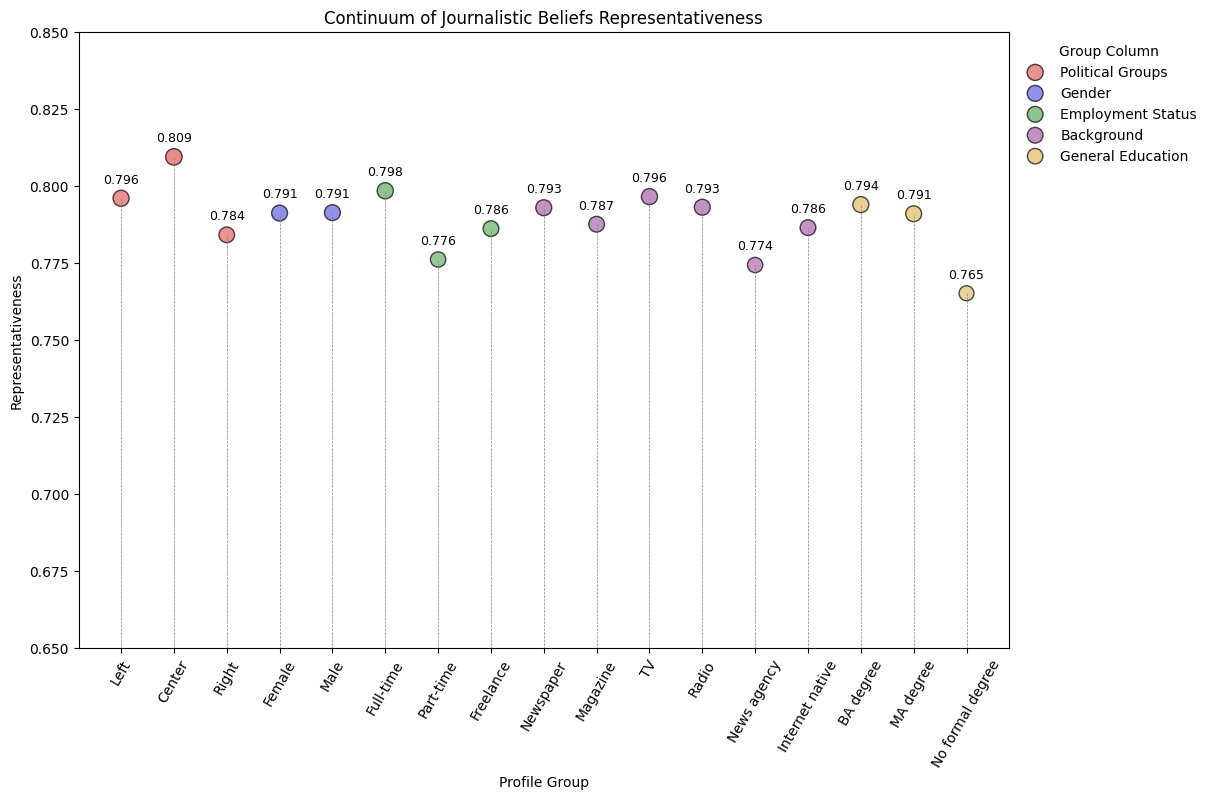

In [ ]:
#Total
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D", "epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E",
             "role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]
manual_title = "Continuum of Journalistic Beliefs Representativeness"

# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, GROUPING_VARIABLES, manual_title)

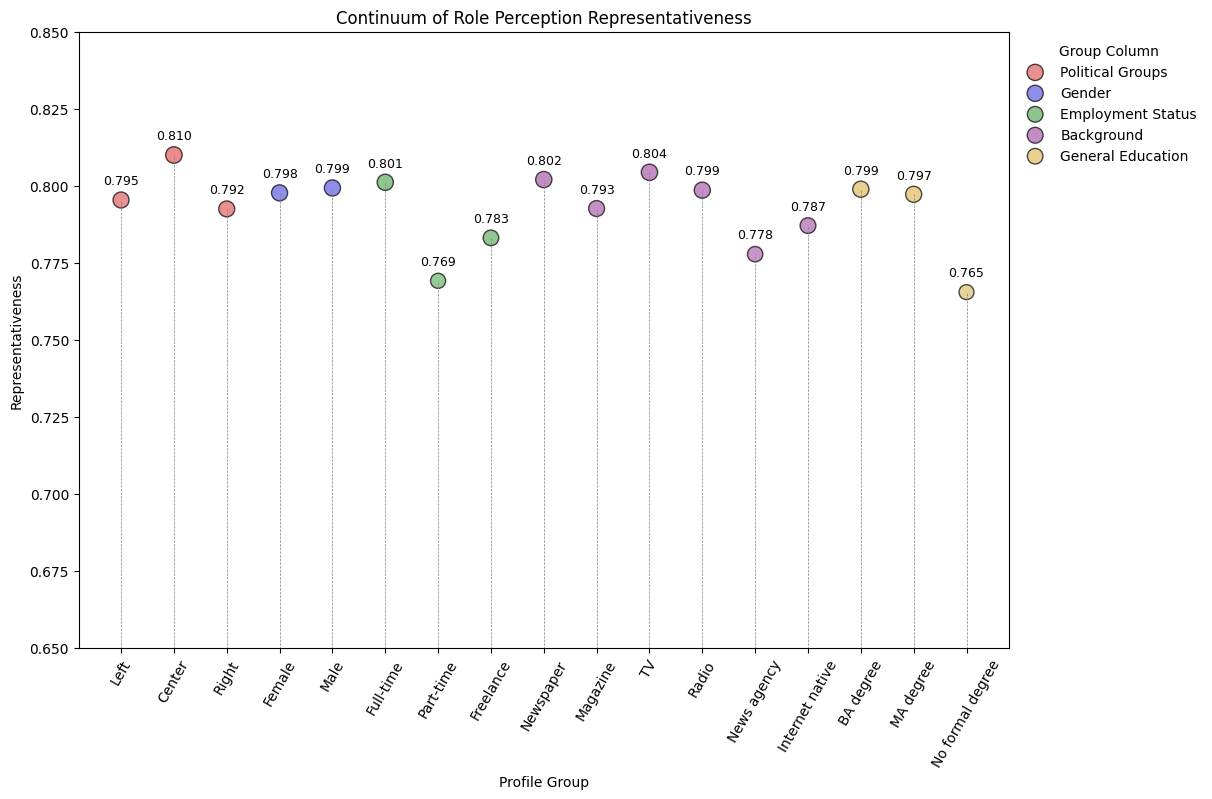

In [ ]:
#Role
variables = ["role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]

manual_title = "Continuum of Role Perception Representativeness"

# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, GROUPING_VARIABLES, manual_title)

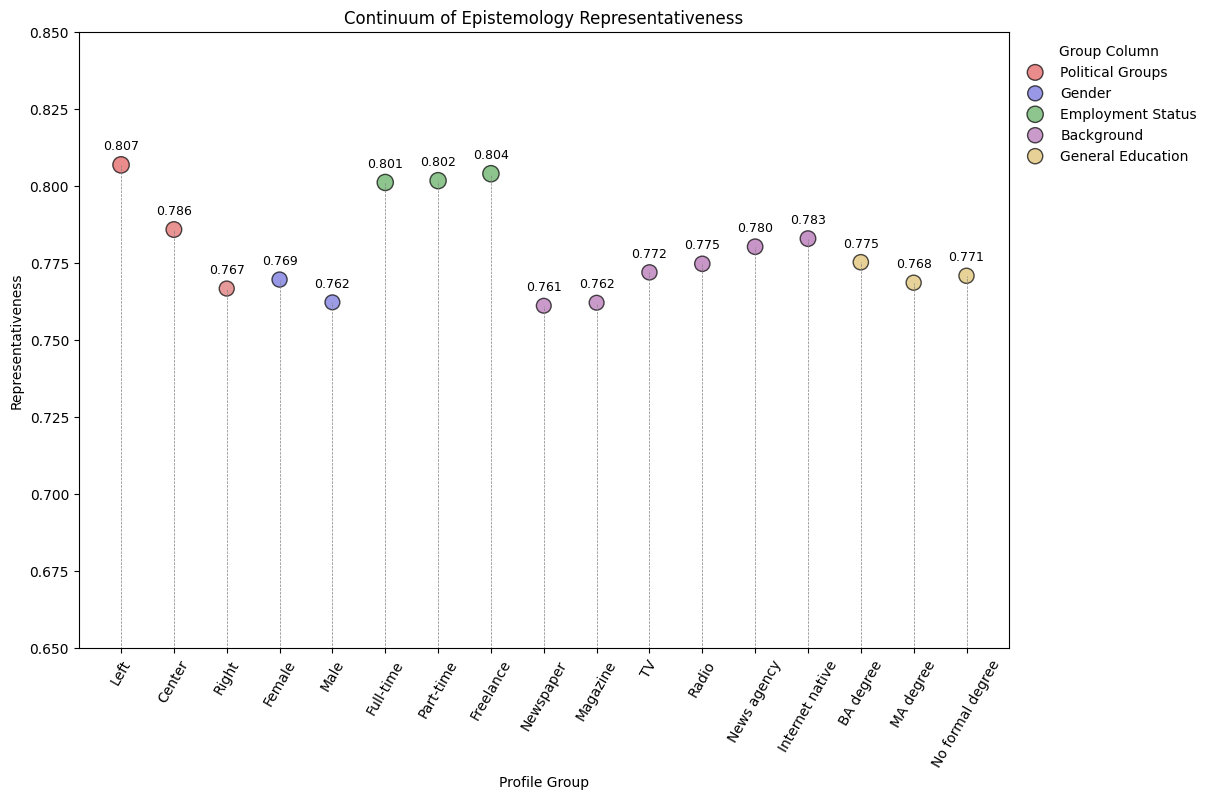

In [ ]:
#Epist
variables = ["epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E"]

manual_title = "Continuum of Epistemology Representativeness"

# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, GROUPING_VARIABLES, manual_title)

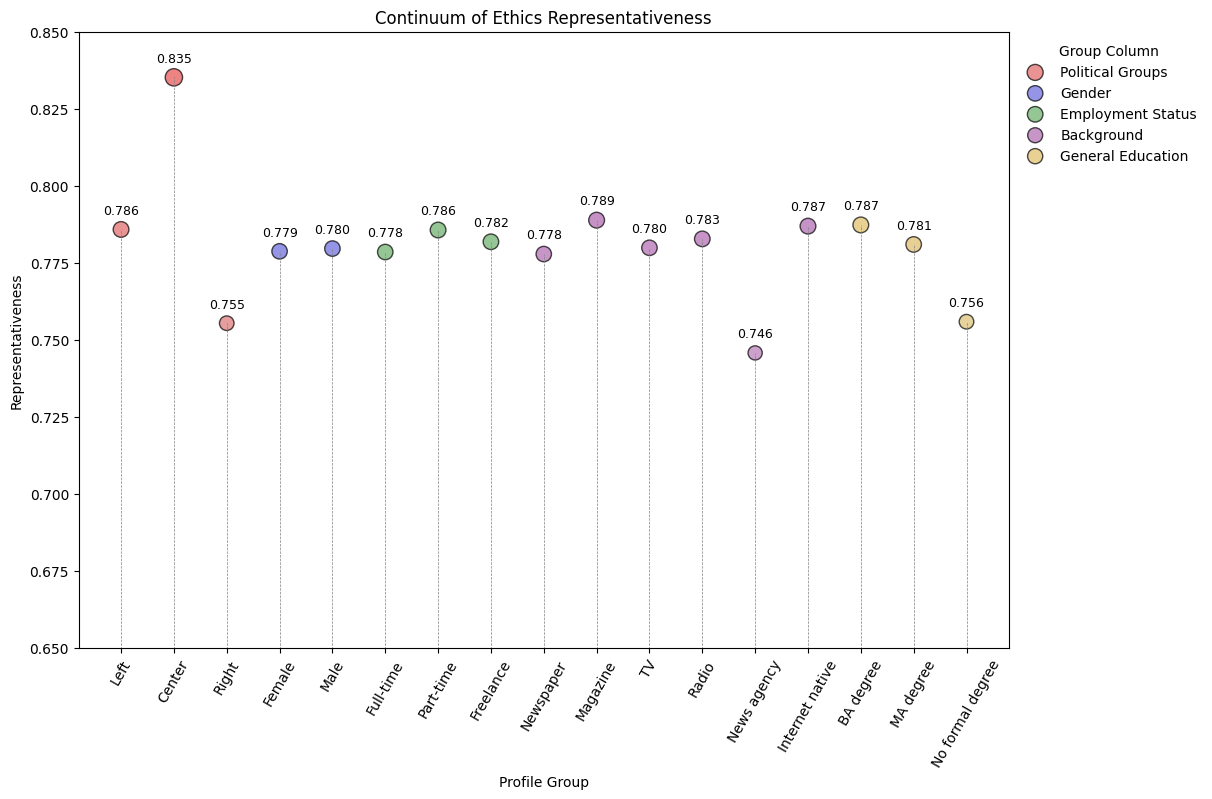

In [ ]:
# Ethics
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D"]

manual_title = "Continuum of Ethics Representativeness"

# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, GROUPING_VARIABLES, manual_title)

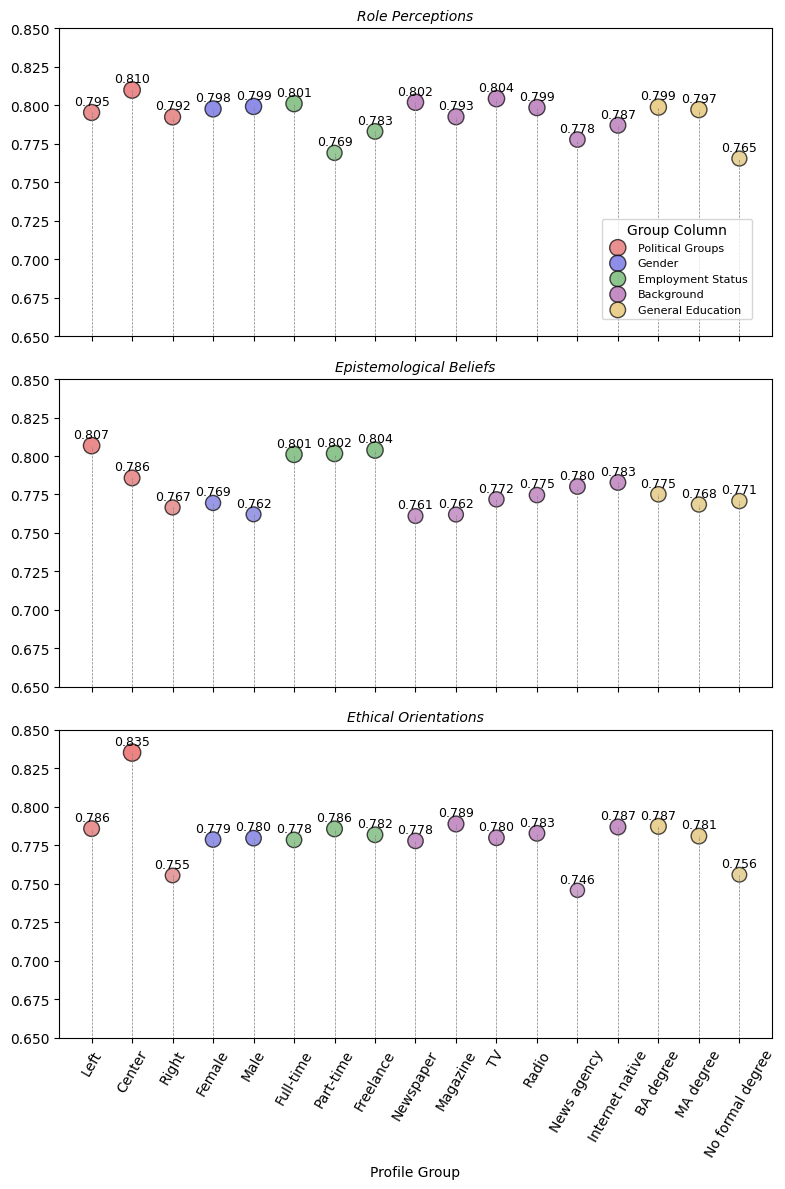

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

# Set up the figure with a vertical grid (3 rows, 1 column)
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # Adjust figsize for letter-size format (8x12)

# Define variables and titles for each plot
plots_data = [
    {
        "variables": ["role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
                      "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
                      "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"],
        "manual_title": "Continuum of Role Perception Representativeness",
        "subtitle": "Role Perceptions"
    },
    {
        "variables": ["epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E"],
        "manual_title": "Continuum of Epistemology Representativeness",
        "subtitle": "Epistemological Beliefs"
    },
    {
        "variables": ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D"],
        "manual_title": "Continuum of Ethics Representativeness",
        "subtitle": "Ethical Orientations"
    }
]

# Function to create the plot
def generate_continuum_plot(ax, human_df, gpt_responses_df, variables, grouping_variables, plot_title, subtitle, is_first_subplot=False):
    all_results = []

    for group_col, group_labels in grouping_variables.items():
        result = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_results.append(result)

    combined_df = pd.concat(all_results, ignore_index=True)

    # Filter data to be within the 0.5 to 1.0 range
    combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

    # Plotting
    for group_col, base_color in color_palette.items():
        group_data = combined_df[combined_df['Group_Column'] == group_col]

        # Create and use the custom colormap for each base color
        cmap = create_colormap(base_color)
        norm = Normalize(vmin=0.65, vmax=1.0)

        # Compute colors based on representativeness (darker as representativeness increases)
        colors = [cmap(norm(val)) for val in group_data['Representativeness']]

        # Compute sizes based on representativeness
        sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

        # Plot the scatter
        scatter = ax.scatter(
            x=group_data['Group'],
            y=group_data['Representativeness'],
            c=colors,
            s=sizes,
            edgecolor='black',
            label=legend_labels.get(group_col, group_col),  # Use custom label here
            alpha=0.7
        )

    # Add text labels on the dots
    for i in range(combined_df.shape[0]):
        ax.text(
            x=combined_df['Group'].iloc[i],
            y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
            s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
            ha='center',
            fontsize=9
        )

    # Add lines connecting the x-axis labels to the dots
    for i in range(combined_df.shape[0]):
        ax.plot(
            [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
            [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
            color='gray', linestyle='--', linewidth=0.5
        )

    ax.axhline(0.5, color='red', linestyle='--')
    ax.set_ylim(0.65, 0.85)
    ax.set_title(plot_title)  # Use the manually provided title
    ax.set_title(subtitle, fontsize=10, style='italic', loc='center')  # Subtitle for each plot

    # Set the x-axis label only for the last (bottom) subplot
    if ax == axs[2]:
        ax.set_xlabel('Profile Group')

    # Remove x-axis labels for all but the last subplot
    if ax != axs[2]:
        ax.set_xticklabels([])

    # Rotate x-ticks for readability
    ax.tick_params(axis='x', rotation=60)

    # Add legend to the first subplot only and make it smaller
    if is_first_subplot:
        ax.legend(title='Group Column', loc='upper right', fontsize=8, frameon=True, bbox_to_anchor=(0.98, 0.40))

# Loop through the plots_data and generate each plot in the corresponding subplot
for i, plot_data in enumerate(plots_data):
    variables = plot_data['variables']
    title = plot_data['manual_title']
    subtitle = plot_data['subtitle']
    is_first_subplot = (i == 0)  # Add legend only to the first subplot
    generate_continuum_plot(axs[i], human_df, gpt_responses_df, variables, GROUPING_VARIABLES, title, subtitle, is_first_subplot)

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the combined plot
plt.show()


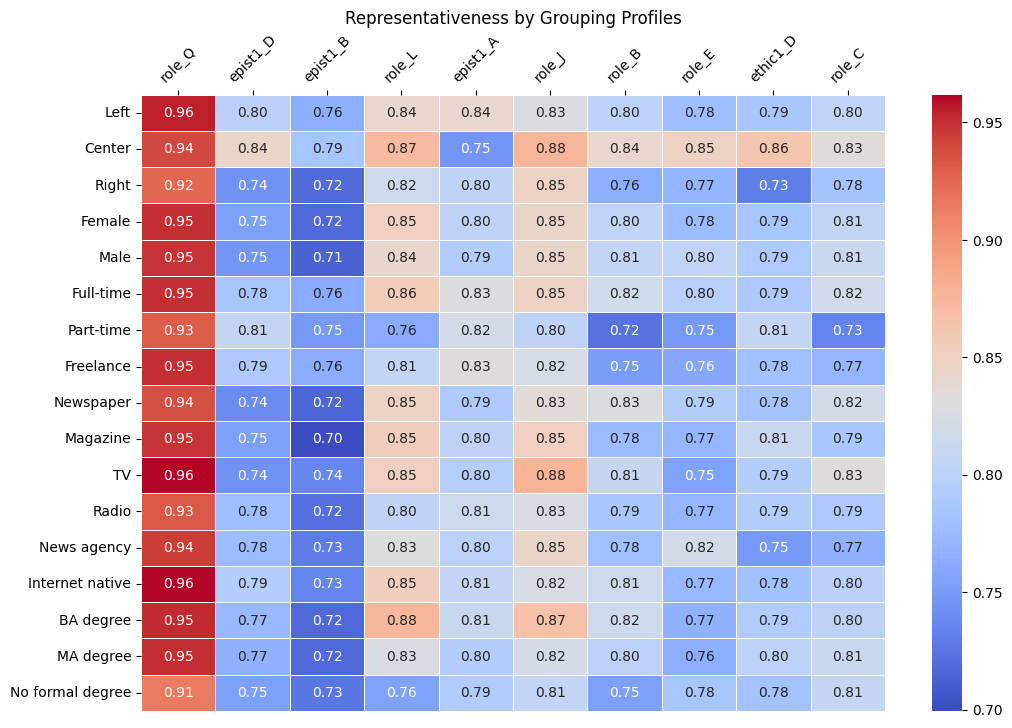

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to compute representativeness for each group
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        rows_list.append(group_distances)

    results_df = pd.DataFrame(rows_list, index=group_labels.values(), columns=variables)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the heatmap
def generate_heatmap(human_df, gpt_responses_df, variables, grouping_variables):
    all_heatmaps = []

    for group_col, group_labels in grouping_variables.items():
        heatmap_data = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_heatmaps.append(heatmap_data)

    # Combine heatmaps
    combined_heatmap_data = pd.concat(all_heatmaps)

    # Generate heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(combined_heatmap_data, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

    # Move the x-axis labels to the top
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')  # Also move the x-axis label to the top

    plt.xticks(rotation=45)
    plt.title('Representativeness by Grouping Profiles')
    plt.show()

# Example usage (previously defined)
variables = ["role_Q", "epist1_D", "epist1_B", "role_L", "epist1_A", "role_J", "role_B", "role_E", "ethic1_D", "role_C"]

# Generate the heatmap
generate_heatmap(human_df, gpt_responses_df, variables, GROUPING_VARIABLES)


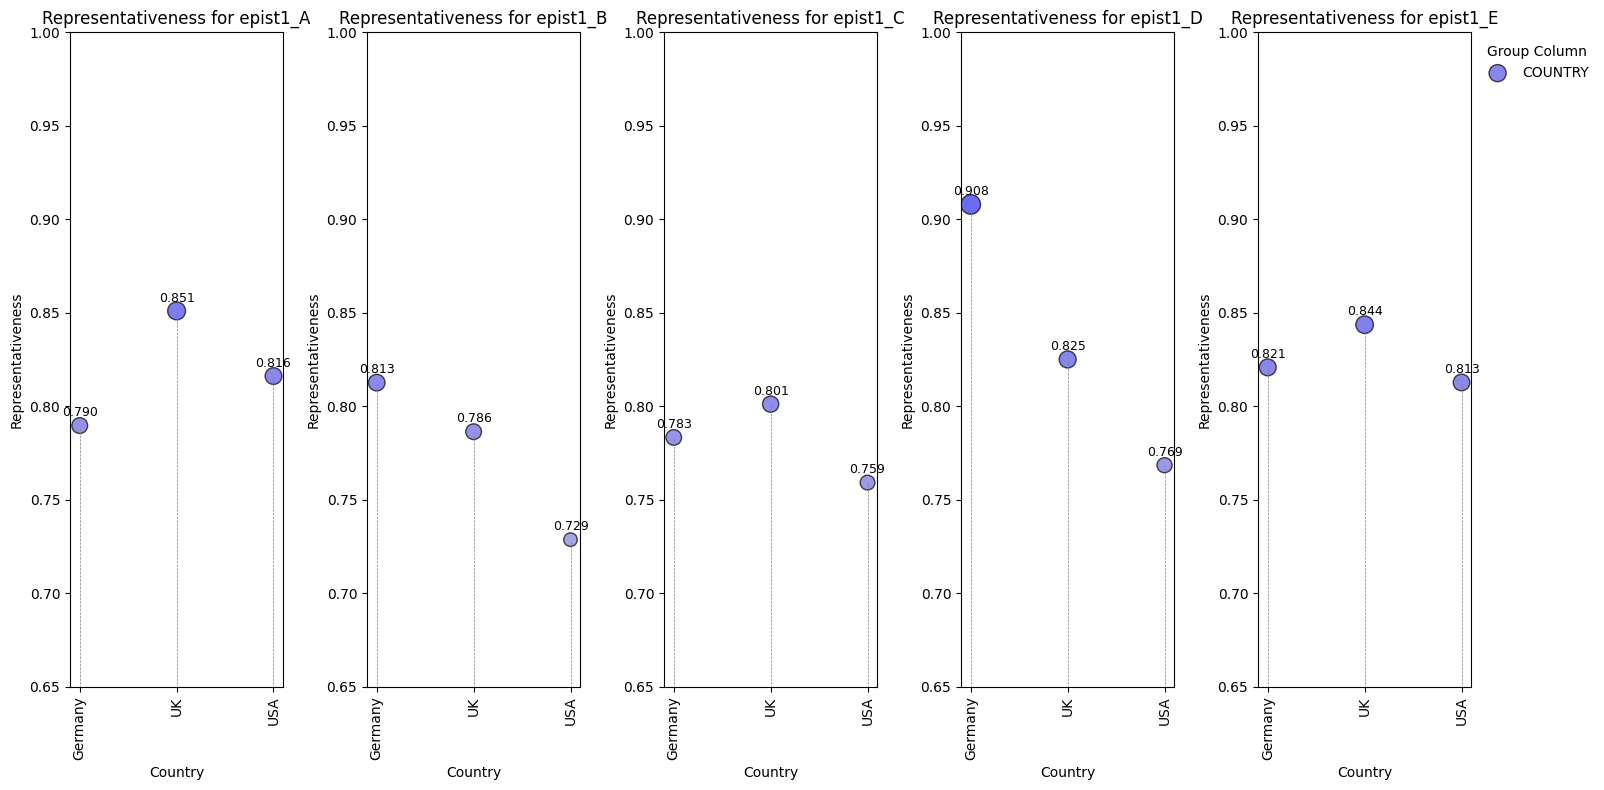

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm, colors as mcolors

# Define a color palette for different groupings
color_palette = {
    'COUNTRY': 'blue'  # Only one grouping variable now: COUNTRY
}

def create_colormap(base_color):
    # Create a colormap with more distinct contrast by using a wider range
    base_rgb = np.array(mcolors.to_rgb(base_color))
    light_color = np.clip(base_rgb + 0.65, 0.65, 0.8)  # Increase to 0.7 to lighten more
    return mcolors.LinearSegmentedColormap.from_list('custom_cmap', [to_hex(light_color), base_color])

# Function to compute representativeness for each group (modified to handle country comparison)
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        if group_distances:
            avg_representativeness = np.nanmean(group_distances)
        else:
            avg_representativeness = np.nan  # Handle empty cases

        row = {
            'Group': group_labels[group],
            'Representativeness': avg_representativeness,
            'Group_Column': group_col
        }
        rows_list.append(row)

    results_df = pd.DataFrame(rows_list)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the continuum plot (separated by variable)
def generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables):
    fig, axes = plt.subplots(1, len(variables), figsize=(15, 8))  # Side-by-side plots

    for idx, var in enumerate(variables):
        all_results = []

        for group_col, group_labels in grouping_variables.items():
            result = compute_representativeness(human_df, gpt_responses_df, [var], group_col, group_labels)
            all_results.append(result)

        combined_df = pd.concat(all_results, ignore_index=True)

        # Filter data to be within the 0.5 to 1.0 range
        combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

        ax = axes[idx]  # Get the axis for the current variable plot

        for group_col, base_color in color_palette.items():
            group_data = combined_df[combined_df['Group_Column'] == group_col]

            # Create and use the custom colormap for each base color
            cmap = create_colormap(base_color)
            norm = Normalize(vmin=0.65, vmax=1.0)

            # Compute colors based on representativeness (darker as representativeness increases)
            colors = [cmap(norm(val)) for val in group_data['Representativeness']]

            # Compute sizes based on representativeness
            sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

            scatter = ax.scatter(
                x=group_data['Group'],
                y=group_data['Representativeness'],
                c=colors,
                s=sizes,
                edgecolor='black',
                label=group_col,
                alpha=0.7
            )

        # Add text labels on the dots
        for i in range(combined_df.shape[0]):
            ax.text(
                x=combined_df['Group'].iloc[i],
                y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
                s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
                ha='center',
                fontsize=9
            )

        # Add lines connecting the x-axis labels to the dots
        for i in range(combined_df.shape[0]):
            ax.plot(
                [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
                [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
                color='gray', linestyle='--', linewidth=0.5
            )

        ax.axhline(0.5, color='red', linestyle='--')
        ax.set_ylim(0.65, 1.0)
        ax.set_xlabel('Country')
        ax.set_ylabel('Representativeness')
        ax.set_title(f'Representativeness for {var}')
        ax.set_xticks(range(len(group_labels)))
        ax.set_xticklabels(list(group_labels.values()), rotation=90)  # Rotate x-axis labels vertically

    plt.tight_layout()
    plt.legend(title='Group Column', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    plt.show()

# Example usage
variables = ["epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E"]  # Only the two variables to compare side by side

grouping_variables = {
    'COUNTRY': {
         28: "Germany", 71: "UK", 72: "USA"
    }
}

# Generate the continuum line plot for each variable side by side
generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables)


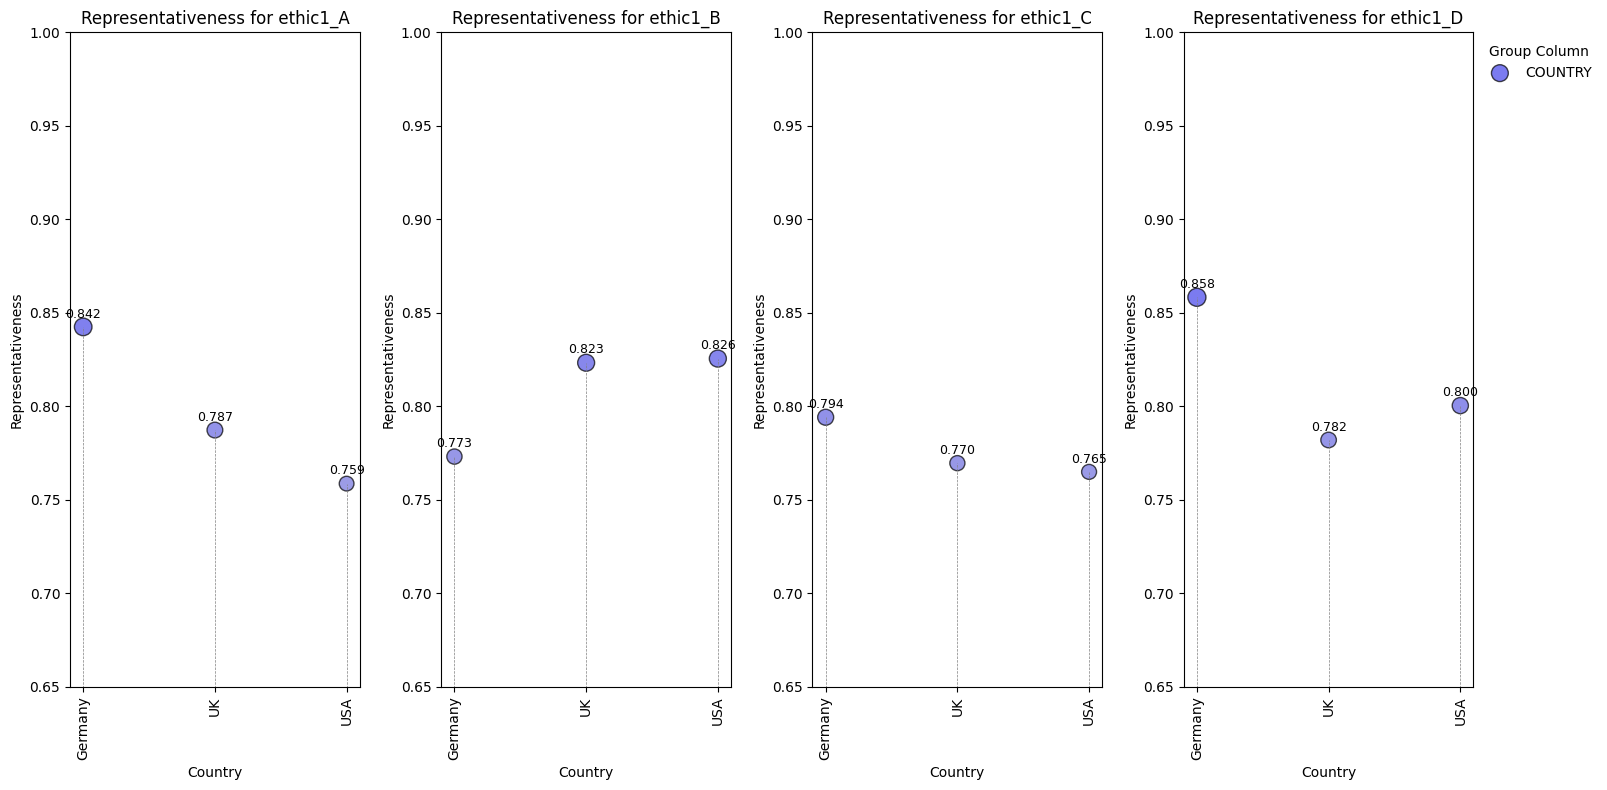

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm, colors as mcolors

# Define a color palette for different groupings
color_palette = {
    'COUNTRY': 'blue'  # Only one grouping variable now: COUNTRY
}

def create_colormap(base_color):
    # Create a colormap with more distinct contrast by using a wider range
    base_rgb = np.array(mcolors.to_rgb(base_color))
    light_color = np.clip(base_rgb + 0.65, 0.65, 0.8)  # Increase to 0.7 to lighten more
    return mcolors.LinearSegmentedColormap.from_list('custom_cmap', [to_hex(light_color), base_color])

# Function to compute representativeness for each group (modified to handle country comparison)
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        if group_distances:
            avg_representativeness = np.nanmean(group_distances)
        else:
            avg_representativeness = np.nan  # Handle empty cases

        row = {
            'Group': group_labels[group],
            'Representativeness': avg_representativeness,
            'Group_Column': group_col
        }
        rows_list.append(row)

    results_df = pd.DataFrame(rows_list)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the continuum plot (separated by variable)
def generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables):
    fig, axes = plt.subplots(1, len(variables), figsize=(15, 8))  # Side-by-side plots

    for idx, var in enumerate(variables):
        all_results = []

        for group_col, group_labels in grouping_variables.items():
            result = compute_representativeness(human_df, gpt_responses_df, [var], group_col, group_labels)
            all_results.append(result)

        combined_df = pd.concat(all_results, ignore_index=True)

        # Filter data to be within the 0.5 to 1.0 range
        combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

        ax = axes[idx]  # Get the axis for the current variable plot

        for group_col, base_color in color_palette.items():
            group_data = combined_df[combined_df['Group_Column'] == group_col]

            # Create and use the custom colormap for each base color
            cmap = create_colormap(base_color)
            norm = Normalize(vmin=0.65, vmax=1.0)

            # Compute colors based on representativeness (darker as representativeness increases)
            colors = [cmap(norm(val)) for val in group_data['Representativeness']]

            # Compute sizes based on representativeness
            sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

            scatter = ax.scatter(
                x=group_data['Group'],
                y=group_data['Representativeness'],
                c=colors,
                s=sizes,
                edgecolor='black',
                label=group_col,
                alpha=0.7
            )

        # Add text labels on the dots
        for i in range(combined_df.shape[0]):
            ax.text(
                x=combined_df['Group'].iloc[i],
                y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
                s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
                ha='center',
                fontsize=9
            )

        # Add lines connecting the x-axis labels to the dots
        for i in range(combined_df.shape[0]):
            ax.plot(
                [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
                [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
                color='gray', linestyle='--', linewidth=0.5
            )

        ax.axhline(0.5, color='red', linestyle='--')
        ax.set_ylim(0.65, 1.0)
        ax.set_xlabel('Country')
        ax.set_ylabel('Representativeness')
        ax.set_title(f'Representativeness for {var}')
        ax.set_xticks(range(len(group_labels)))
        ax.set_xticklabels(list(group_labels.values()), rotation=90)  # Rotate x-axis labels vertically

    plt.tight_layout()
    plt.legend(title='Group Column', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    plt.show()

# Example usage
variables = ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D"]  # Only the two variables to compare side by side

grouping_variables = {
    'COUNTRY': {
         28: "Germany", 71: "UK", 72: "USA"
    }
}

# Generate the continuum line plot for each variable side by side
generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables)


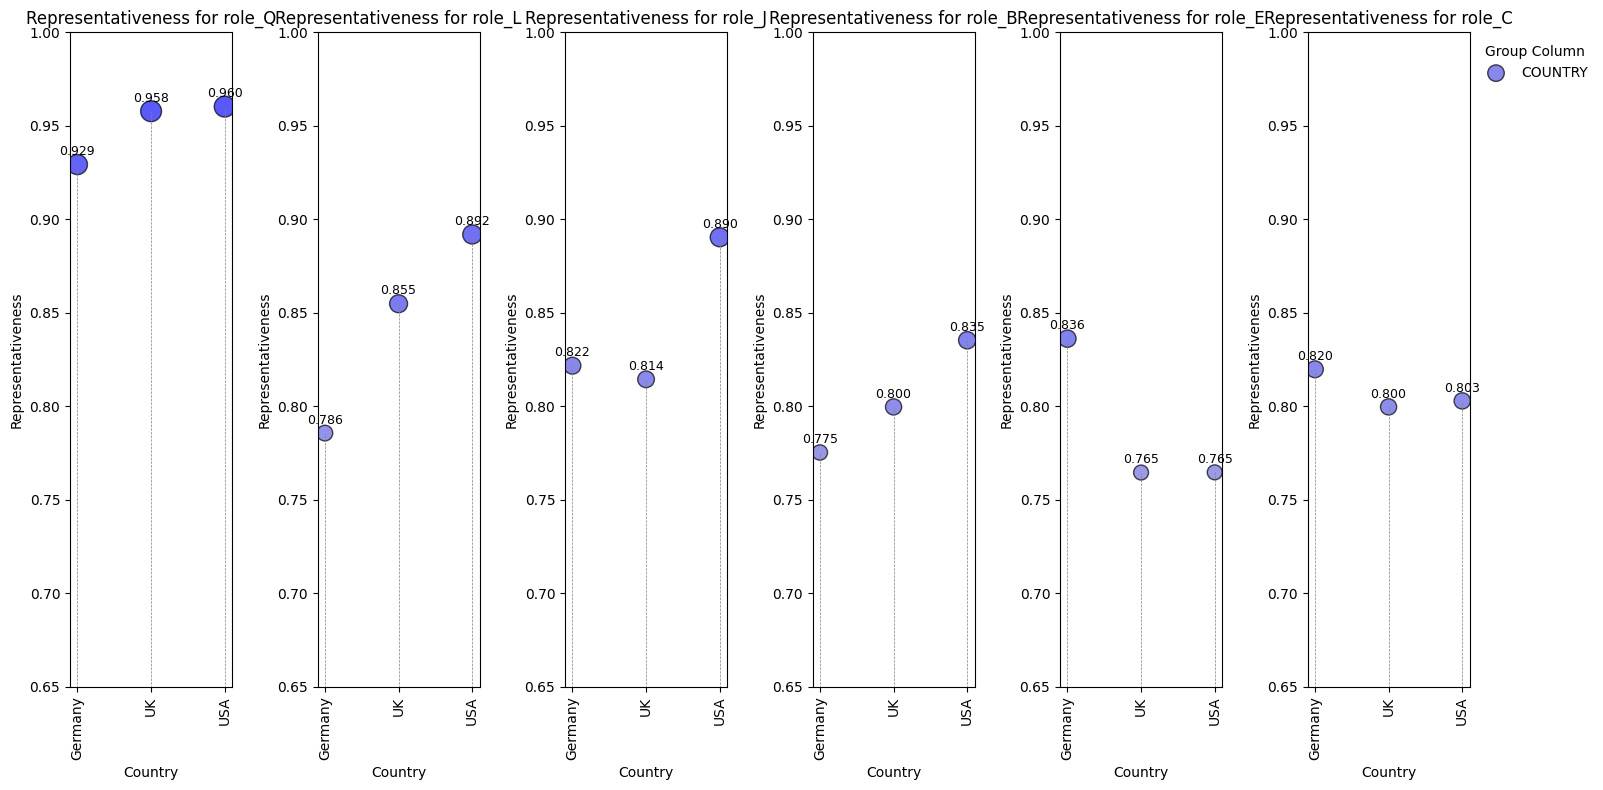

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm, colors as mcolors

# Define a color palette for different groupings
color_palette = {
    'COUNTRY': 'blue'  # Only one grouping variable now: COUNTRY
}

def create_colormap(base_color):
    # Create a colormap with more distinct contrast by using a wider range
    base_rgb = np.array(mcolors.to_rgb(base_color))
    light_color = np.clip(base_rgb + 0.65, 0.65, 0.8)  # Increase to 0.7 to lighten more
    return mcolors.LinearSegmentedColormap.from_list('custom_cmap', [to_hex(light_color), base_color])

# Function to compute representativeness for each group (modified to handle country comparison)
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        if group_distances:
            avg_representativeness = np.nanmean(group_distances)
        else:
            avg_representativeness = np.nan  # Handle empty cases

        row = {
            'Group': group_labels[group],
            'Representativeness': avg_representativeness,
            'Group_Column': group_col
        }
        rows_list.append(row)

    results_df = pd.DataFrame(rows_list)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the continuum plot (separated by variable)
def generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables):
    fig, axes = plt.subplots(1, len(variables), figsize=(15, 8))  # Side-by-side plots

    for idx, var in enumerate(variables):
        all_results = []

        for group_col, group_labels in grouping_variables.items():
            result = compute_representativeness(human_df, gpt_responses_df, [var], group_col, group_labels)
            all_results.append(result)

        combined_df = pd.concat(all_results, ignore_index=True)

        # Filter data to be within the 0.5 to 1.0 range
        combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

        ax = axes[idx]  # Get the axis for the current variable plot

        for group_col, base_color in color_palette.items():
            group_data = combined_df[combined_df['Group_Column'] == group_col]

            # Create and use the custom colormap for each base color
            cmap = create_colormap(base_color)
            norm = Normalize(vmin=0.65, vmax=1.0)

            # Compute colors based on representativeness (darker as representativeness increases)
            colors = [cmap(norm(val)) for val in group_data['Representativeness']]

            # Compute sizes based on representativeness
            sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

            scatter = ax.scatter(
                x=group_data['Group'],
                y=group_data['Representativeness'],
                c=colors,
                s=sizes,
                edgecolor='black',
                label=group_col,
                alpha=0.7
            )

        # Add text labels on the dots
        for i in range(combined_df.shape[0]):
            ax.text(
                x=combined_df['Group'].iloc[i],
                y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
                s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
                ha='center',
                fontsize=9
            )

        # Add lines connecting the x-axis labels to the dots
        for i in range(combined_df.shape[0]):
            ax.plot(
                [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
                [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
                color='gray', linestyle='--', linewidth=0.5
            )

        ax.axhline(0.5, color='red', linestyle='--')
        ax.set_ylim(0.65, 1.0)
        ax.set_xlabel('Country')
        ax.set_ylabel('Representativeness')
        ax.set_title(f'Representativeness for {var}')
        ax.set_xticks(range(len(group_labels)))
        ax.set_xticklabels(list(group_labels.values()), rotation=90)  # Rotate x-axis labels vertically

    plt.tight_layout()
    plt.legend(title='Group Column', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
    plt.show()

# Example usage
variables = ["role_Q", "role_L", "role_J", "role_B", "role_E"]  # Only the two variables to compare side by side

grouping_variables = {
    'COUNTRY': {
         28: "Germany", 71: "UK", 72: "USA"
    }
}

# Generate the continuum line plot for each variable side by side
generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables)


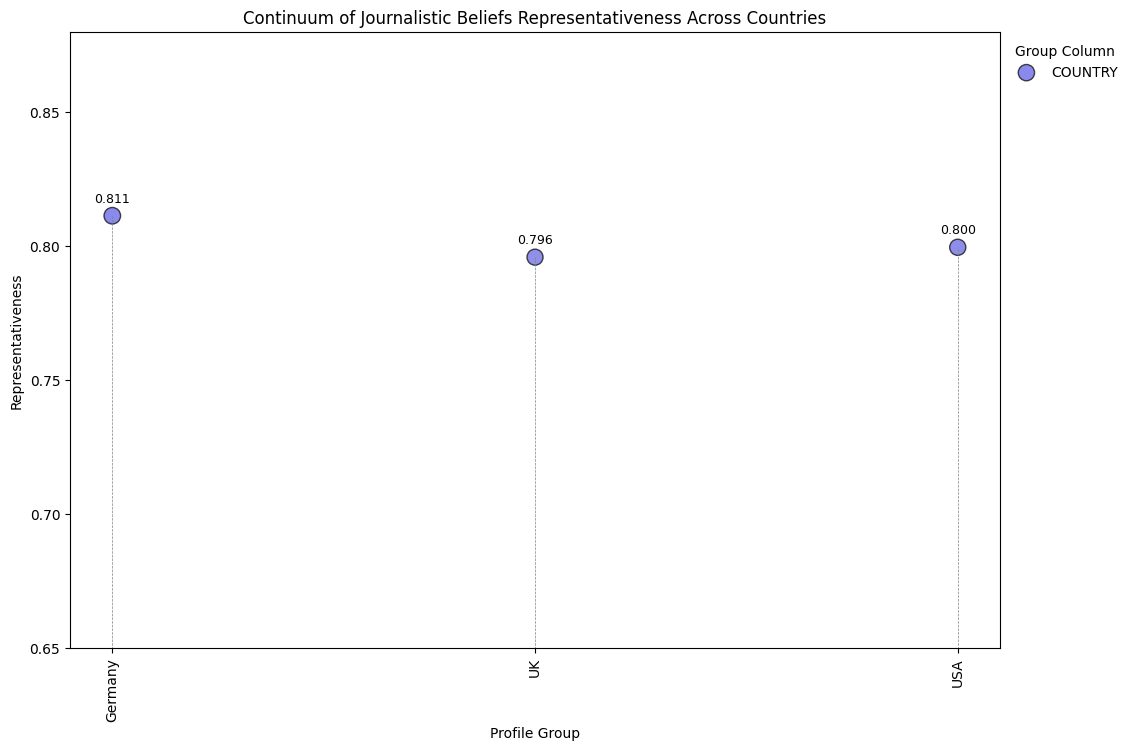

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize, to_hex
from matplotlib import cm, colors as mcolors

# Define a color palette for different groupings
color_palette = {
    'COUNTRY': 'blue'  # Only one grouping variable now: COUNTRY
}

def create_colormap(base_color):
    # Create a colormap with more distinct contrast by using a wider range
    base_rgb = np.array(mcolors.to_rgb(base_color))
    light_color = np.clip(base_rgb + 0.65, 0.65, 0.8)  # Increase to 0.7 to lighten more
    return mcolors.LinearSegmentedColormap.from_list('custom_cmap', [to_hex(light_color), base_color])

# Function to compute representativeness for each group
def compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels):
    rows_list = []

    for group in group_labels.keys():
        group_distances = []

        for var in variables:
            gpt_response = int(gpt_responses_df.loc[gpt_responses_df['Variable_Name'] == var, 'Response'].values[0])
            human_distribution = human_df[human_df[group_col] == group][var].value_counts(normalize=True).sort_index()

            if not human_distribution.empty:
                distance = compute_wasserstein_distance(human_distribution, gpt_response)
                group_distances.append(1 - distance)  # Representativeness is 1 - Wasserstein Distance
            else:
                group_distances.append(np.nan)

        if group_distances:
            avg_representativeness = np.nanmean(group_distances)
        else:
            avg_representativeness = np.nan  # Handle empty cases

        row = {
            'Group': group_labels[group],
            'Representativeness': avg_representativeness,
            'Group_Column': group_col
        }
        rows_list.append(row)

    results_df = pd.DataFrame(rows_list)
    return results_df

# Function to compute Wasserstein distance
def compute_wasserstein_distance(human_distribution, gpt_response):
    options = human_distribution.index
    human_probs = human_distribution.values
    gpt_value = gpt_response

    # Create a distribution for GPT response
    gpt_probs = np.zeros_like(human_probs)
    if gpt_value in options:
        gpt_probs[options.get_loc(gpt_value)] = 1

    # Check if the distribution is empty
    if len(human_probs) == 0 or len(gpt_probs) == 0:
        return np.nan

    # Compute Wasserstein distance
    distance = wasserstein_distance(gpt_probs, human_probs)
    return distance

# Function to generate the continuum plot
def generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables):
    all_results = []

    for group_col, group_labels in grouping_variables.items():
        result = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
        all_results.append(result)

    combined_df = pd.concat(all_results, ignore_index=True)

    # Filter data to be within the 0.5 to 1.0 range
    combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

    # Plotting
    plt.figure(figsize=(12, 8))

    for group_col, base_color in color_palette.items():
        group_data = combined_df[combined_df['Group_Column'] == group_col]

        # Create and use the custom colormap for each base color
        cmap = create_colormap(base_color)
        norm = Normalize(vmin=0.65, vmax=1.0)

        # Compute colors based on representativeness (darker as representativeness increases)
        colors = [cmap(norm(val)) for val in group_data['Representativeness']]

        # Compute sizes based on representativeness
        sizes = 50 + 200 * norm(group_data['Representativeness'])  # Scale sizes

        scatter = plt.scatter(
            x=group_data['Group'],
            y=group_data['Representativeness'],
            c=colors,
            s=sizes,
            edgecolor='black',
            label=group_col,
            alpha=0.7
        )

    # Add text labels on the dots
    for i in range(combined_df.shape[0]):
        plt.text(
            x=combined_df['Group'].iloc[i],
            y=combined_df['Representativeness'].iloc[i] + 0.005,  # Adjust for better visibility
            s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
            ha='center',
            fontsize=9
        )

    # Add lines connecting the x-axis labels to the dots
    for i in range(combined_df.shape[0]):
        plt.plot(
            [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],  # x-coordinates: same value for start and end
            [0.5, combined_df['Representativeness'].iloc[i]],              # y-coordinates: from 0.5 to the dot's y-value
            color='gray', linestyle='--', linewidth=0.5
        )

    plt.axhline(0.5, color='red', linestyle='--')
    plt.ylim(0.65, 0.88)
    plt.xlabel('Profile Group')
    plt.ylabel('Representativeness')
    plt.title('Continuum of Journalistic Beliefs Representativeness Across Countries')
    plt.xticks(rotation=90)  # Rotate x-axis labels vertically
    plt.legend(title='Group Column', loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    plt.show()

# Example usage
variables = ["epist1_A", "epist1_B", "epist1_C", "epist1_D",
             "epist1_E", "ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D",
             "role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]

grouping_variables = {
    'COUNTRY': {
         28: "Germany", 71: "UK", 72: "USA"
    }
}

# Generate the continuum line plot
generate_continuum_plot(human_df, gpt_responses_df, variables, grouping_variables)

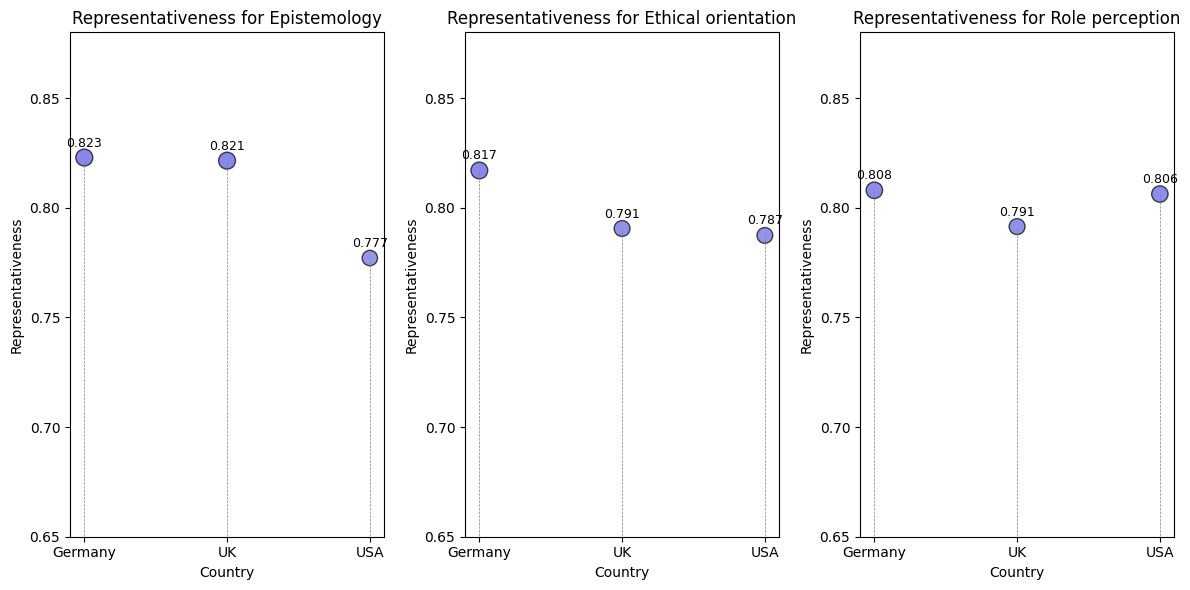

In [ ]:
# Grouped variables for epist, ethic, and role
grouped_variables = {
    'epistemology': ["epist1_A", "epist1_B", "epist1_C", "epist1_D", "epist1_E"],
    'ethical orientation': ["ethic1_A", "ethic1_B", "ethic1_C", "ethic1_D"],
    'role perception': ["role_A", "role_B", "role_C", "role_D", "role_E", "role_F", "role_G", "role_H",
             "role_I", "role_J", "role_K", "role_L", "role_M", "role_N", "role_O", "role_P",
             "role_Q", "role_R", "role_S", "role_T", "role_U", "role_X", "role_Y", "role_V"]
}
# Function to generate the continuum plot with multiple subplots
def generate_combined_continuum_plot(human_df, gpt_responses_df, grouped_variables, grouping_variables):
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))  # Adjusted figure size to be less wide

    # Iterate through the groups of variables and axes
    for ax, (category, variables) in zip(axes, grouped_variables.items()):
        all_results = []

        for group_col, group_labels in grouping_variables.items():
            result = compute_representativeness(human_df, gpt_responses_df, variables, group_col, group_labels)
            all_results.append(result)

        combined_df = pd.concat(all_results, ignore_index=True)

        # Filter data to be within the 0.5 to 1.0 range
        combined_df = combined_df[(combined_df['Representativeness'] >= 0.5) & (combined_df['Representativeness'] <= 1.0)]

        # Plotting for each subplot
        for group_col, base_color in color_palette.items():
            group_data = combined_df[combined_df['Group_Column'] == group_col]

            # Create and use the custom colormap for each base color
            cmap = create_colormap(base_color)
            norm = Normalize(vmin=0.65, vmax=1.0)

            # Compute colors and sizes based on representativeness
            colors = [cmap(norm(val)) for val in group_data['Representativeness']]
            sizes = 50 + 200 * norm(group_data['Representativeness'])

            ax.scatter(
                x=group_data['Group'],
                y=group_data['Representativeness'],
                c=colors,
                s=sizes,
                edgecolor='black',
                label=group_col,
                alpha=0.7
            )

        # Add text labels on the dots
        for i in range(combined_df.shape[0]):
            ax.text(
                x=combined_df['Group'].iloc[i],
                y=combined_df['Representativeness'].iloc[i] + 0.005,
                s=f"{combined_df['Representativeness'].iloc[i]:.3f}",
                ha='center',
                fontsize=9
            )

        # Add lines connecting the x-axis labels to the dots
        for i in range(combined_df.shape[0]):
            ax.plot(
                [combined_df['Group'].iloc[i], combined_df['Group'].iloc[i]],
                [0.5, combined_df['Representativeness'].iloc[i]],
                color='gray', linestyle='--', linewidth=0.5
            )

        ax.axhline(0.5, color='red', linestyle='--')
        ax.set_ylim(0.65, 0.88)
        ax.set_xlabel('Country')  # Changed x-axis label to 'Country'
        ax.set_ylabel('Representativeness')
        ax.set_title(f'Representativeness for {category.capitalize()}')
        ax.tick_params(axis='x', rotation=0)  # No x-axis rotation
        ax.set_xticks(range(len(group_data['Group'])))
        ax.set_xticklabels(group_data['Group'], ha='center')  # Labels centered and no rotation

    plt.subplots_adjust(wspace=0.25)  # Adjust space between subplots
    plt.tight_layout()  # Fit the subplots within the figure
    plt.show()

# Generate the combined continuum line plots
generate_combined_continuum_plot(human_df, gpt_responses_df, grouped_variables, grouping_variables)
